# Label Studio

In [1]:
# ======================================================
# === SAFE CLEAN + AUTO YOLO DATASET PREPARATION PIPELINE ===
# ======================================================

import os
import random
import shutil
import yaml
from zipfile import ZipFile
from google.colab import files

# === 1. ASK USER TO UPLOAD ZIP FILE ===
print("\n📂 Please upload your dataset ZIP file (e.g. dataset.zip)...")
uploaded = files.upload()

if len(uploaded) == 0:
    raise Exception("❌ No file uploaded. Please upload a ZIP dataset.")

# Get uploaded filename
zip_path = list(uploaded.keys())[0]
print(f"✅ Uploaded file: {zip_path}")

# === 2. UNZIP DATASET ===
extract_dir = "dataset"

# Remove old dataset folder if it exists
if os.path.exists(extract_dir):
    shutil.rmtree(extract_dir)

with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f"✅ Unzipped dataset to: {extract_dir}\n")

# === 3. DEFINE PATHS ===
images_dir = os.path.join(extract_dir, "images")
labels_dir = os.path.join(extract_dir, "labels")

train_images = os.path.join(images_dir, "train")
val_images = os.path.join(images_dir, "val")
train_labels = os.path.join(labels_dir, "train")
val_labels = os.path.join(labels_dir, "val")

# Create required directories
for d in [train_images, val_images, train_labels, val_labels]:
    os.makedirs(d, exist_ok=True)

# === 4. SPLIT DATASET ===
image_files = [
    f for f in os.listdir(images_dir)
    if f.lower().endswith(('.jpg', '.jpeg', '.png'))
]

if not image_files:
    raise ValueError("❌ No images found in dataset/images folder.")

random.shuffle(image_files)
split_index = int(0.8 * len(image_files))
train_files = image_files[:split_index]
val_files = image_files[split_index:]

def move_files(file_list, src_img, src_lbl, dst_img, dst_lbl):
    for f in file_list:
        name, _ = os.path.splitext(f)
        img_src = os.path.join(src_img, f)
        lbl_src = os.path.join(src_lbl, f"{name}.txt")

        if os.path.exists(img_src):
            shutil.move(img_src, dst_img)
        else:
            print(f"⚠️ Missing image: {f}")

        if os.path.exists(lbl_src):
            shutil.move(lbl_src, dst_lbl)
        else:
            print(f"⚠️ No label found for {f}")

# Move train/val data
move_files(train_files, images_dir, labels_dir, train_images, train_labels)
move_files(val_files, images_dir, labels_dir, val_images, val_labels)

print(f"✅ Train images: {len(train_files)}")
print(f"✅ Val images: {len(val_files)}")

# Clean any leftover files
for f in os.listdir(images_dir):
    fp = os.path.join(images_dir, f)
    if os.path.isfile(fp):
        os.remove(fp)

# === 5. READ CLASS NAMES ===
classes_path = os.path.join(extract_dir, "classes.txt")
if not os.path.exists(classes_path):
    raise FileNotFoundError("❌ 'classes.txt' not found in dataset folder.")

with open(classes_path, "r") as f:
    class_names = [line.strip() for line in f if line.strip()]

# === 6. CREATE data.yaml ===
data_yaml = {
    "train": os.path.abspath(train_images),
    "val": os.path.abspath(val_images),
    "nc": len(class_names),
    "names": class_names
}

yaml_path = os.path.join(extract_dir, "data.yaml")
with open(yaml_path, "w") as f:
    yaml.dump(data_yaml, f, sort_keys=False)

print("\n✅ Created data.yaml:")
print(yaml.dump(data_yaml, sort_keys=False))
print("✅ Dataset ready for YOLO training.\n")


🧹 Checking current folders and files in /content...

📂 Current files and folders:
1. .config
2. sample_data

❓ Do you want to remove any of these? (y/n): y
👉 Enter numbers to delete (comma separated) or 'all' to remove everything: all
✅ All items removed.

📂 Please upload your dataset ZIP file (e.g. dataset.zip)...


KeyboardInterrupt: 

# Training YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 71.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.

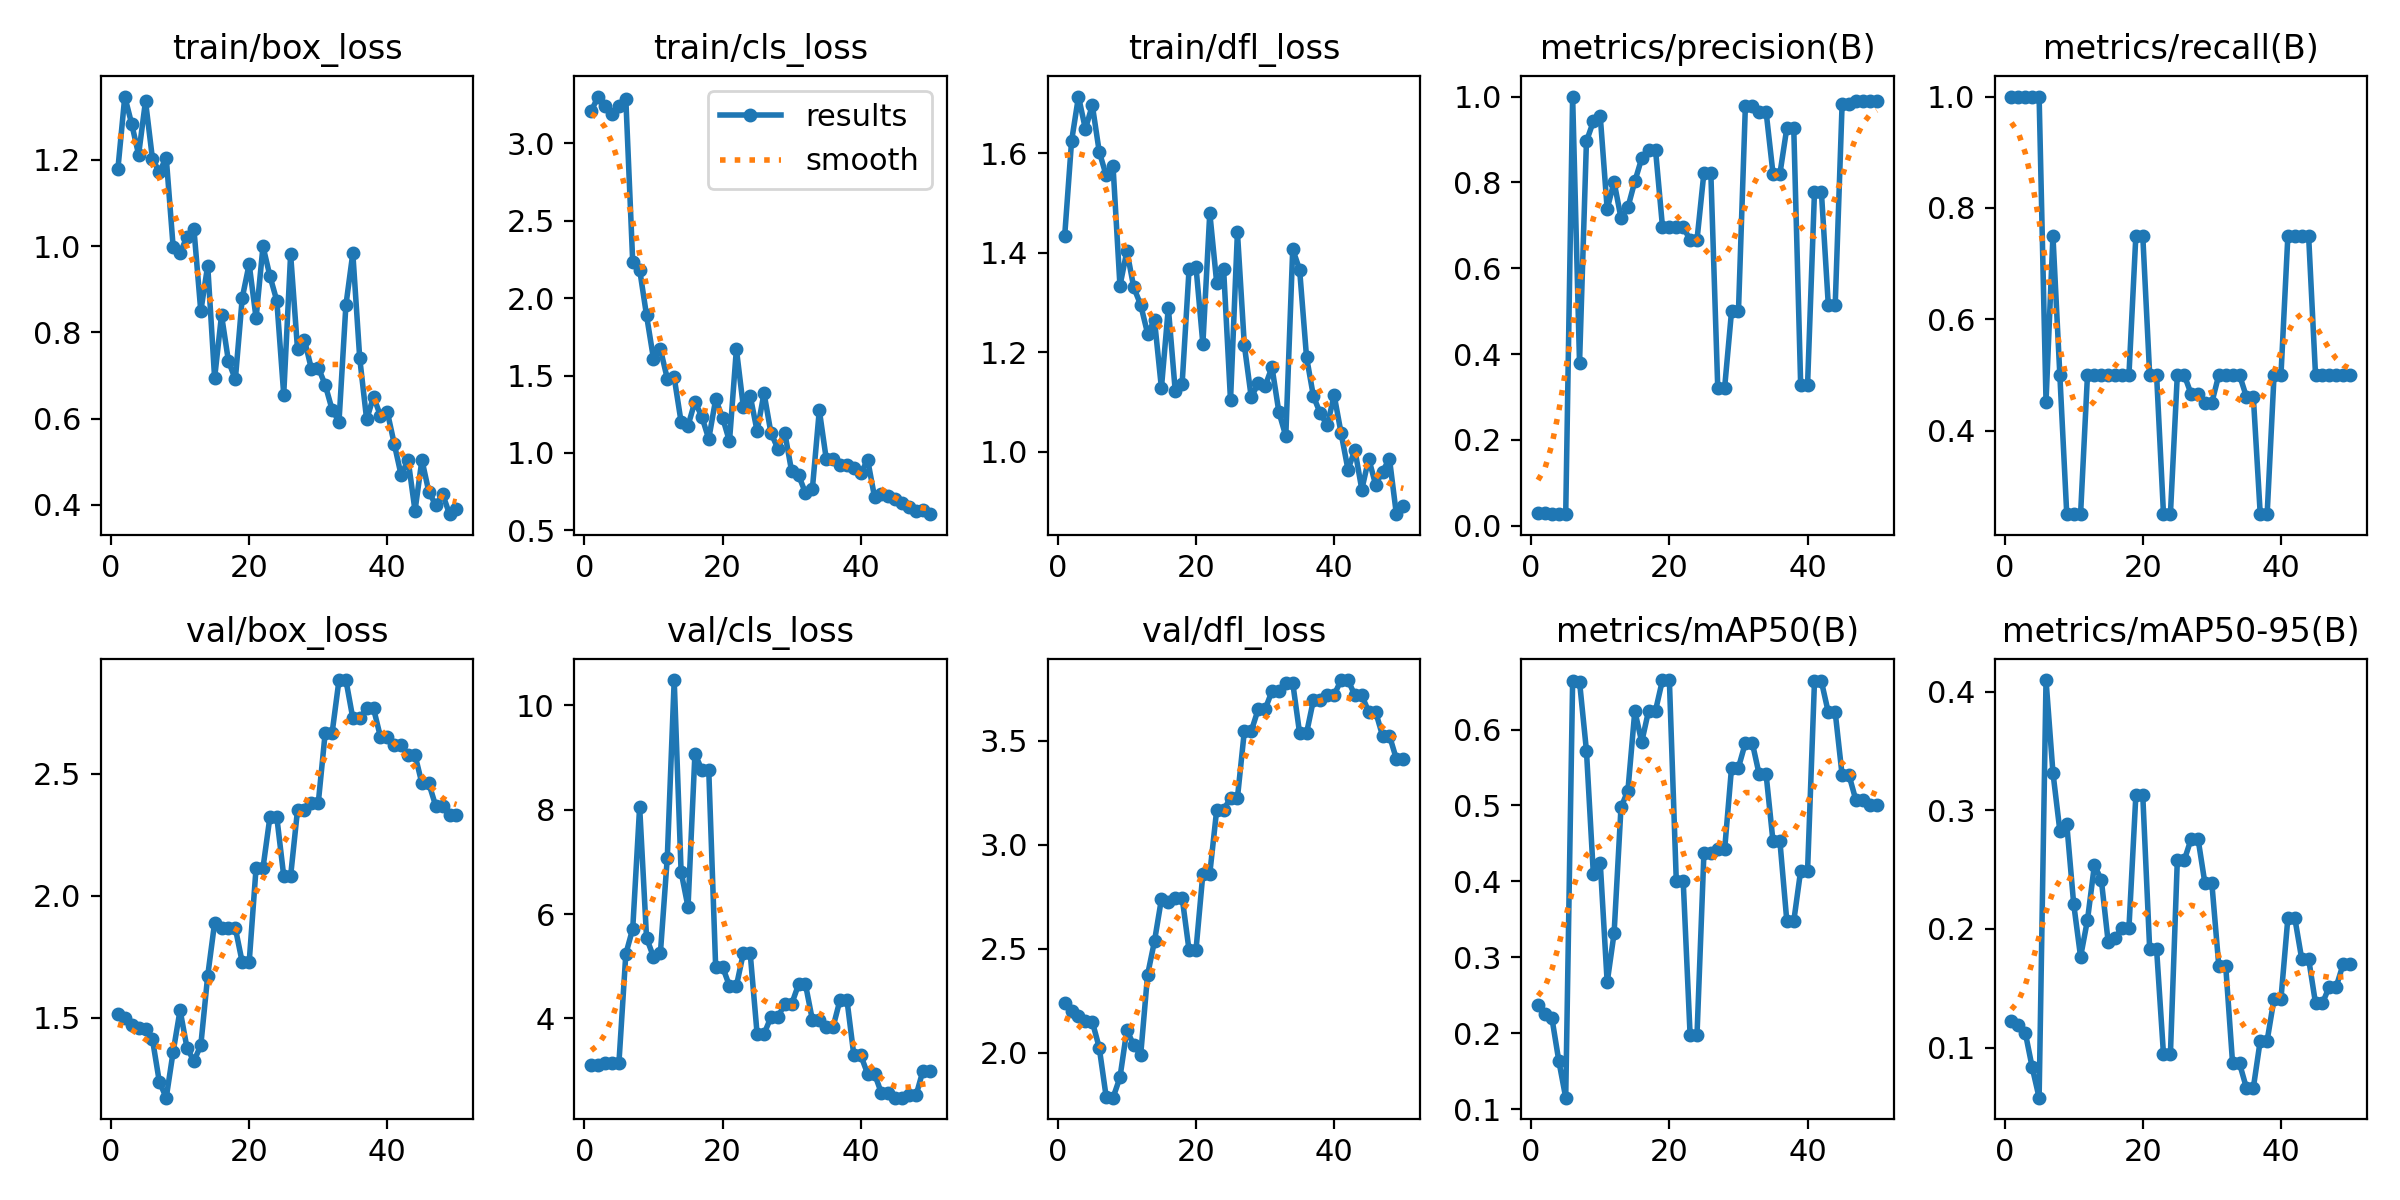

In [3]:
# ==========================
# === YOLO TRAINING PART ===
# ==========================

# 1. Install YOLOv8
!pip install ultralytics -q

# 2. Import YOLO
from ultralytics import YOLO
from IPython.display import Image, display
import os

# 3. Train YOLO model
# You can change the model to yolov8n.pt, yolov8s.pt, yolov8m.pt, yolov8l.pt, etc.
model = YOLO("yolov8m.pt")

results = model.train(
    data="dataset/data.yaml",  # path to your YAML file
    epochs=50,                 # number of training epochs
    imgsz=640,                 # image size
    batch=16,                  # adjust if you hit memory errors
)

# 4. Show training summary image
print("\n📊 Training results:")
display(Image(filename='runs/detect/train/results.png'))

# Predict Results


🔎 Evaluating model on validation data...
Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,840,918 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1390.0±697.7 MB/s, size: 54.2 KB)
val: Scanning /content/dataset/labels/val.cache... 2 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2/2 4.3Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 8.1it/s 0.1s
                   all          2          4          1      0.452      0.663       0.41
                   cat          2          2          1          0      0.332      0.221
                   dog          2          2          1      0.904      0.995      0.599
Speed: 0.9ms preprocess, 39.2ms inference, 0.0ms loss, 8.9ms postprocess per image
Results saved to /content/runs/detect/val
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_clas

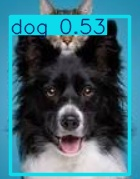

In [4]:
# 5. Evaluate trained model
print("\n🔎 Evaluating model on validation data...")
metrics = model.val()
print(metrics)

# 6. Run inference (test on validation images)
print("\n🧠 Running inference on validation set...")
results = model.predict(source="dataset/images/val",
    conf=0.3, # only keep boxes with ≥30% confidence
    iou=0.6, # NMS IoU threshold
    save=True)
print("✅ Predictions saved in runs/detect/predict/")

# 7. Display example prediction
pred_dir = "runs/detect/predict"
if os.path.exists(pred_dir):
    preds = [f for f in os.listdir(pred_dir) if f.endswith(('.jpg', '.png'))]
    if preds:
        display(Image(filename=os.path.join(pred_dir, preds[0])))
    else:
        print("⚠️ No predictions found.")
else:
    print("⚠️ Prediction directory not found.")


# New data

✅ Loaded model from: runs/detect/train/weights/best.pt

📂 Upload one or more images for prediction...


Saving Screenshot 2025-10-27 154100.png to Screenshot 2025-10-27 154100.png

🔍 Predicting on: Screenshot 2025-10-27 154100.png

image 1/1 /content/Screenshot 2025-10-27 154100.png: 512x640 (no detections), 48.1ms
Speed: 2.2ms preprocess, 48.1ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 640)
Results saved to /content/runs/detect/user_upload

✅ Displaying predictions:


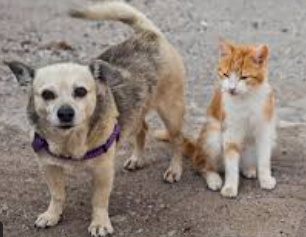

In [5]:
# ================================
# === USER IMAGE PREDICTION ===
# ================================

from ultralytics import YOLO
from google.colab import files
from IPython.display import Image, display
import os

# 1. Load your trained model
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)
print(f"✅ Loaded model from: {model_path}")

# 2. Upload image(s)
print("\n📂 Upload one or more images for prediction...")
uploaded = files.upload()

if len(uploaded) == 0:
    raise Exception("❌ No file uploaded.")

# 3. Run inference
for filename in uploaded.keys():
    print(f"\n🔍 Predicting on: {filename}")
    results = model.predict(
        source=filename,
        conf=0.3,
        iou=0.6,
        agnostic_nms=False,
        save=True,
        project="runs/detect",
        name="user_upload",
        exist_ok=False  # create new folder each time
    )

# 4. Display results
pred_dir = "runs/detect/user_upload"
if os.path.exists(pred_dir):
    preds = [f for f in os.listdir(pred_dir) if f.lower().endswith(('.jpg', '.png'))]
    if preds:
        print("\n✅ Displaying predictions:")
        for pred in preds:
            display(Image(filename=os.path.join(pred_dir, pred)))
    else:
        print("⚠️ No prediction images found.")
else:
    print("⚠️ Prediction folder not found.")


# Video

In [6]:
# ================================
# === USER VIDEO PREDICTION ===
# ================================

from ultralytics import YOLO
from google.colab import files
from IPython.display import HTML
from base64 import b64encode
import os

# 1. Load your trained model
model_path = "runs/detect/train/weights/best.pt"
model = YOLO(model_path)
print(f"✅ Loaded model from: {model_path}")

# 2. Upload video
print("\n📂 Upload a video file for prediction (e.g. video.mp4)...")
uploaded = files.upload()

if len(uploaded) == 0:
    raise Exception("❌ No video uploaded.")

video_name = list(uploaded.keys())[0]
print(f"✅ Uploaded video: {video_name}")

# 3. Run inference
print(f"\n🔍 Running prediction on: {video_name}")
results = model.predict(
    source=video_name,
    conf=0.3,
    iou=0.6,
    agnostic_nms=False,
    save=True,
    project="runs/detect",
    name="video_upload",
    exist_ok=False  # create new folder each time
)

# 4. Locate output video
pred_dir = "runs/detect/video_upload"
output_video = None

if os.path.exists(pred_dir):
    for f in os.listdir(pred_dir):
        if f.lower().endswith(('.mp4', '.mov', '.avi')):
            output_video = os.path.join(pred_dir, f)
            break

# 5. Display and auto-download
if output_video:
    print(f"\n✅ Detection complete. Displaying video result:")
    mp4 = open(output_video, "rb").read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    display(HTML(f'<video width=640 controls><source src="{data_url}" type="video/mp4"></video>'))

    print("\n📦 Preparing download...")
    files.download(output_video)
    print(f"✅ Video ready for download: {output_video}")
else:
    print("⚠️ No output video found.")


✅ Loaded model from: runs/detect/train/weights/best.pt

📂 Upload a video file for prediction (e.g. video.mp4)...


Saving tmpcbpb2loj.mp4 to tmpcbpb2loj.mp4
✅ Uploaded video: tmpcbpb2loj.mp4

🔍 Running prediction on: tmpcbpb2loj.mp4

WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/81) /content/tmpcbpb2loj.mp4: 512x640 (no detections), 28.6ms
video 1/1 (frame 2/81) /content/tmpcbpb2loj.mp4: 512x640 1 dog, 27.9ms
video 1/1 (frame 3/81) /content/tmpcbpb2loj.mp4: 512x640 1 dog, 24.2ms
video 1/1 (frame 4/81) /content/tmpcbpb2loj.mp4: 512x640 1 dog, 24.2ms
video 1/1 (frame 5/81) /content/tmpcbpb2loj.


📦 Preparing download...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Video ready for download: runs/detect/video_upload/tmpcbpb2loj.avi
